<a href="https://colab.research.google.com/github/cvillela/amplemarket_challenge/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Amplemarket Machine Learning Engineer Challenge

Caio Simão Villela - csvillela1@gmail.com

---

# B2B and B2C Classification Model for Companies

This project aims to create a classification model that can differentiate between B2B (business-to-business) and B2C (business-to-consumer) companies based on their company profile data.

The model is developed using XGBoost, an efficient implementation of gradient boosting algorithms that has gained popularity due to its high accuracy and fast computation. To improve the model's performance, Optuna, an automatic hyperparameter optimization framework, is used to find the optimal set of hyperparameters for the model.

The trained model is then exposed through a Flask API that can be locally hosted. Users can input the company profile data, and the model will classify the company as B2B, B2C, both or neither.

# Installs
---

In [27]:
!pip install optuna
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.0 MB/s eta 0:00:00


## Imports
---

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import gspread

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import optuna

# Import the Data
---

Since I did not want to create a public URL containing the provided Amplemarket company dataset, I am going to manually update the dataset contained in the github repository / provided google sheets.

In [12]:
from google.colab import files 
 
uploaded = files.upload()

Saving data.csv to data.csv


# Exploratory Data Analysis
---

In [46]:
df = pd.read_csv('./data.csv')

In [47]:
pd.set_option('display.max_columns', None)

In [48]:
df.head()

,name,alexa_rank,city,state,country,hq,website,employees_on_linkedin,followers,founded,industry,linkedin_url,overview,ownership_type,sic_codes,size,specialties,total_funding,technologies,company_hubs,events,categories,type
0,Supli,NaN,Paris,√éle-de-France,France,"Paris, √éle-de-France",https://supli.com/,22,1074,2017.0,Restaurants,https://www.linkedin.com/company/supli,Lib√©rez votre activit√© avec la plateforme de...,Partnership,NaN,11-50 employees,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,NaN,NaN,B2B
1,Bandwidth Recruitment,NaN,Hove,England,United Kingdom,"Hove, East Sussex",http://www.bandwidthrecruitment.com,2,484,2009.0,Staffing and Recruiting,https://www.linkedin.com/company/bandwidth-rec...,Bandwidth Recruitment is an independent specia...,Privately Held,NaN,2-10 employees,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...",NaN,PAY 360,"Consulting, Human Resources, Insurance, Small ...",B2B
2,VCV.AI,NaN,Menlo Park,California,United States,"Menlo Park, California",http://vcv.ai/,40,877,2017.0,Information Technology and Services,https://www.linkedin.com/company/vcv-ai,VCV automates 4 steps of recruitment in one fr...,Privately Held,NaN,11-50 employees,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Companies with a .AI domain, Growjo 10000, 500...",NaN,"Artificial Intelligence, Recruiting, Human Res...",B2B
3,"Scalable Press Employees, Location, Careers",NaN,Newark,California,United States,"Newark, California",https://scalablepress.com,112,11322,2012.0,Printing,https://www.linkedin.com/company/scalablepress,At Scalable Press we're building the next gene...,Public Company,NaN,501-1000 employees,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...",NaN,Integrated Systems Europe 2020,"Software Engineering, Retail Technology, Indus...",B2B B2C
4,Stuffwrap,NaN,NaN,NaN,Unknown,Unknown,http://www.stuffwrap.com,0,21,2012.0,Information Services,https://www.linkedin.com/company/stuffwrap,Stuffwrap is a platform where you turn your wi...,Public Company,NaN,2-10 employees,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,NaN,NaN,"Information Services, Social Network,",B2C


In [49]:
df.columns

Index(['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'employees_on_linkedin', 'followers', 'founded', 'industry',
       'linkedin_url', 'overview', 'ownership_type', 'sic_codes', 'size',
       'specialties', 'total_funding', 'technologies', 'company_hubs',
       'events', 'categories', 'type'],
      dtype='object')

In [50]:
df.describe()

,alexa_rank,employees_on_linkedin,followers,founded,total_funding
count,214.000000,1799.000000,1799.000000,1543.000000,1.799000e+03
mean,415985.294393,43.559755,1504.840467,2010.705768,3.039968e+07
std,278537.061488,304.762881,5883.113006,12.341825,8.312451e+08
min,33.000000,0.000000,0.000000,1825.000000,0.000000e+00
25%,161458.750000,2.000000,21.000000,2010.000000,0.000000e+00
50%,400686.000000,6.000000,127.000000,2014.000000,0.000000e+00
75%,632575.250000,18.000000,680.500000,2016.000000,0.000000e+00
max,991704.000000,10011.000000,147481.000000,2021.000000,3.395000e+10


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   1799 non-null   object 
 1   alexa_rank             214 non-null    float64
 2   city                   1459 non-null   object 
 3   state                  1426 non-null   object 
 4   country                1699 non-null   object 
 5   hq                     1676 non-null   object 
 6   website                1798 non-null   object 
 7   employees_on_linkedin  1799 non-null   int64  
 8   followers              1799 non-null   int64  
 9   founded                1543 non-null   float64
 10  industry               1771 non-null   object 
 11  linkedin_url           1799 non-null   object 
 12  overview               1773 non-null   object 
 13  ownership_type         1672 non-null   object 
 14  sic_codes              93 non-null     object 
 15  size

In [56]:
df['type'].value_counts(dropna=False)

B2B        1312
B2B B2C     315
B2C         172
Name: type, dtype: int64

In [52]:
# df_fund = df.loc[df.total_funding!=0]
# sns.histplot(df_fund, x='total_funding', bins=40)

In [53]:

# fig, ax = plt.subplots(1, 1, figsize = (16, 8))

# sns.histplot(data=df, x='events', hue='type')

# # # title and axis
# ax.set_title('Analized Companies per Country',  size='x-large')
# ax.set_ylabel('Number of Companies', size='small', color='C0')
# ax.tick_params(axis='y', colors='C0')
# # ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# # ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# # ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
# plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

# plt.gcf().subplots_adjust(bottom=0.3)

# plt.show()

In [54]:
# fig, ax = plt.subplots(1, 1, figsize = (16, 8))

# sns.histplot(data=df, x='country', hue='type', discrete=True, stat='percent')

# # # title and axis
# ax.set_title('Analized Companies per Country',  size='x-large')
# ax.set_ylabel('Number of Companies', size='small', color='C0')
# ax.tick_params(axis='y', colors='C0')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# # ax.set_xticks(np.arange(len(list(dict_ret_geral.keys()))))
# # ax.set_xticklabels(labels=list(dict_ret_geral.keys()))
# plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')

# plt.gcf().subplots_adjust(bottom=0.3)

# plt.show()

## Data Preprocessing
---

### Removing Columns

In this step I remove some of the Dataset columns which are not likely to be useful for our model prediction fit.

By removing geospatial data such as City, State, Country and HQ , I also avoid Geospatial Biases to be produced by the model, ....

The following plots show no apparent corelation between ....

The company overview does contain useful information on the company "type", but given the unstructured nature of the data and the time constraints on the project at hand, I have decided not to dabble too much on feature engineering over the descriptive texts and disregard the "overview" on my classification model. 

there is also too little data on 'company_hubs' and 'events', with a significant ammount of missing values for those fields on the provided dataset. For that reason I have also chosen not to use those fields on the company type classification model training.

In [77]:
df_clean = df.drop(columns=['name', 'alexa_rank', 'city', 'state', 'country', 'hq', 'website',
       'linkedin_url', 'overview', 'sic_codes', 'company_hubs', 'events'])

In [78]:
df_clean

,employees_on_linkedin,followers,founded,industry,ownership_type,size,specialties,total_funding,technologies,categories,type
0,22,1074,2017.0,Restaurants,Partnership,11-50 employees,"saas, ERP, plateforme, restauration, grossiste...",0,NaN,NaN,B2B
1,2,484,2009.0,Staffing and Recruiting,Privately Held,2-10 employees,Cards and payments recruitment,0,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B
2,40,877,2017.0,Information Technology and Services,Privately Held,11-50 employees,"assessment, recruitment, selection, hiring, HR...",150000,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B
3,112,11322,2012.0,Printing,Public Company,501-1000 employees,"Promotional Products Supplier, Industrial Auto...",0,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C
4,0,21,2012.0,Information Services,Public Company,2-10 employees,"Sale and swap your stuff, Buying and selling, ...",0,Microsoft ASP.NET,"Information Services, Social Network,",B2C
...,...,...,...,...,...,...,...,...,...,...,...
1794,2,6,NaN,Executive Office,Privately Held,0-1 employees,"Wellness Management, Entertainment & Film, and...",0,Campaign Monitor,"Financial Services,",B2B
1795,22,123,2013.0,Management Consulting,Privately Held,NaN,"Mergers & Acquisitions, Financial modelling, S...",0,NaN,"Information Technology, Consulting, CRM,",B2B
1796,3,89,1964.0,Facilities Services,Privately Held,11-50 employees,"Forensic Investigations, Roof Asset Management...",0,NaN,"Construction, Facilities Support Services, , A...",B2B
1797,0,15,2014.0,Real Estate,Privately Held,2-10 employees,"real estate technology, lead generation",125000,"YouTube, Amazon Route 53","Internet, Mobile, Video Streaming, Real Estate,",B2B


### Feature Engineering
---

In [79]:
from transformers import pipeline

#### total_funding:
we have data on total_funding for all of our values, nevertheless only 441 companies do have funding, and the funding varies immensely between them. So I will create a categorical feature "has_funding" to describe wether a company had funding or not. 

In [80]:
df_clean['has_funding'] = 0
df_clean.loc[df_clean['total_funding']!=0, 'has_funding'] = 1
# df_clean=df_clean.drop(columns=['total_funding'])

#### size:
we need to preprocess the strings to exctract information

In [81]:
df_clean['size'] = df_clean['size'].str.replace(r'[^0-9\-]+', '')

<ipython-input-81-1909f25729f6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean['size'] = df_clean['size'].str.replace(r'[^0-9\-]+', '')


<Axes: xlabel='size', ylabel='Count'>

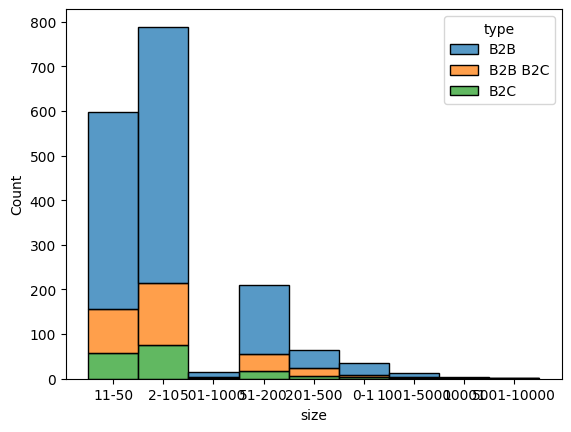

In [82]:
sns.histplot(data=df_clean, x='size', hue='type', multiple='stack')

In [83]:
df_clean.loc[df_clean['size']=='10001', 'size']='200+'
df_clean.loc[df_clean['size']=='5001-10000', 'size']='200+'
df_clean.loc[df_clean['size']=='1001-5000', 'size']='200+'
df_clean.loc[df_clean['size']=='501-1000', 'size']='200+'
df_clean.loc[df_clean['size']=='201-500', 'size']='200+'
df_clean.loc[df_clean['size']=='0-1', 'size']='1-10'
df_clean.loc[df_clean['size']=='2-10', 'size']='1-10'

In [84]:
df_clean['size'].value_counts()

1-10      824
11-50     597
51-200    209
200+       96
Name: size, dtype: int64

<Axes: xlabel='size', ylabel='Count'>

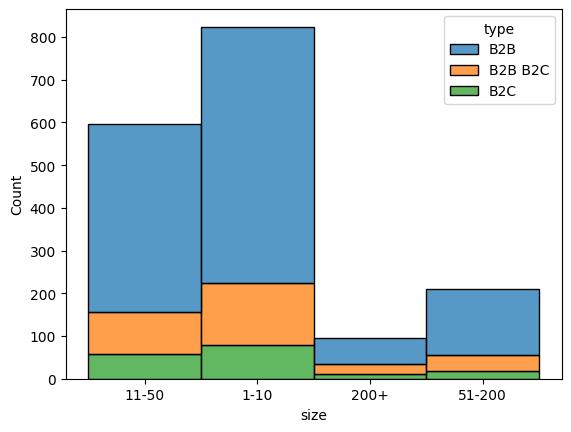

In [85]:
sns.histplot(data=df_clean, x='size', hue='type', multiple='stack')

#### specialties:
specialties provides us with valuable information on the company's industry. For the information to be useful, NLP preprocessing must be used for feature extraction, as the terms are too diverse and one-hot encoding of the categories as they are would not be feaseble

In [86]:
df_clean['specialties']

0       saas, ERP, plateforme, restauration, grossiste...
1                          Cards and payments recruitment
2       assessment, recruitment, selection, hiring, HR...
3       Promotional Products Supplier, Industrial Auto...
4       Sale and swap your stuff, Buying and selling, ...
                              ...                        
1794    Wellness Management, Entertainment & Film, and...
1795    Mergers & Acquisitions, Financial modelling, S...
1796    Forensic Investigations, Roof Asset Management...
1797              real estate technology, lead generation
1798    Commercial Insurance, Global Insurance, Health...
Name: specialties, Length: 1799, dtype: object

In [87]:
for spec in df_clean['specialties'][:5]:
    print(spec)
    print('---')

saas, ERP, plateforme, restauration, grossiste, fournisseur, application de commandes, canal d'acquisition de nouveaux clients
---
Cards and payments recruitment
---
assessment, recruitment, selection, hiring, HR, recruiting, automation, AI, proctoring, video resume, Videointerview
---
Promotional Products Supplier, Industrial Automation, Promotional Merchandise, ASI, Custom Printed Apparel, PPAI, Shopify Integration, Custom Printed Hard Goods, JIT Printing, Programmatic Printing, White-label Fulfillment
---
Sale and swap your stuff, Buying and selling, Create have list and wish list, B2c
---


NLP Processing: industry classification

In [89]:
industry_sectors=['Insurance',
                  'Marketing',
                  'Finance',
                  'Sales',
                  'Health',
                  'Security',
                  'Government',
                  'Restaurant',
                  'HR',
                  'Technology']

# Load pre-trained BERT model
classifier = pipeline(model="facebook/bart-large-mnli", label_list=industry_sectors)


# Define example text to classify
example_text = "assessment, recruitment, selection, hiring, HR, recruiting, automation, AI, proctoring, video resume, Videointerview"

# Use pre-trained model to predict category of example text
predicted_category = classifier(example_text, candidate_labels=industry_sectors,)

# Print predicted category
for label, scores in zip(predicted_category['labels'], predicted_category['scores']):
  print(label, ' : ', scores)

HR  :  0.8269288539886475
Technology  :  0.12449122220277786
Restaurant  :  0.010070949792861938
Health  :  0.007979236543178558
Government  :  0.00626852922141552
Sales  :  0.0059578148648142815
Security  :  0.005559055600315332
Marketing  :  0.004854781087487936
Finance  :  0.004317536484450102
Insurance  :  0.0035720677115023136


In [ ]:
# df_clean = df_clean.drop(columns=['specialties'])

#### industry:
industry provides us with valuable information on the company's actuation sector. There are only 114 distinct values for industry, thus we will try to one-hot encode these categories without more complex feature engineering on the first attempt

In [ ]:
df_clean.industry.value_counts()

Information Technology and Services    318
Internet                               260
Computer Software                      205
Marketing and Advertising              190
Financial Services                      62
                                      ... 
Plastics                                 1
Health, Wellness & Fitness               1
Maritime                                 1
Chemicals                                1
Non-Profit Organization Management       1
Name: industry, Length: 114, dtype: int64

In [94]:
industry_labels = [
  'Technology and Software',
  'Marketing and Advertising',
  'Finance and Investment', 
  'Consulting and Professional Services',
  'Real Estate and Property',
  'Retail and Consumer Goods',
  'Hospitality and Tourism',
  'Healthcare and Medical Devices',
  'Transportation and Logistics',
  'Education and Non-profit Organizations'
] 

#### categories:
categories also provides us with valuable information on the company's actuation sector. There are 1537 distinct values for industry, so some category grouping needs to be done

In [ ]:
df_clean.categories.value_counts()

Advertising, Marketing,                                             21
E-Commerce, ,                                                       13
Marketing,                                                          13
E-Commerce,                                                         11
Software,                                                           11
                                                                    ..
Publishing, Digital Media, Beauty, Fashion, Lifestyle,               1
Leisure, Marketplace, Reservations,                                  1
Automotive, Service Industry, Consumer Electronics, , Recycling,     1
Consulting, , Legal                                                  1
Consulting, Marketing, Sales, ,                                      1
Name: categories, Length: 1537, dtype: int64

In [ ]:
df_clean.categories.value_counts()[:50]

Advertising, Marketing,                                                       21
E-Commerce, ,                                                                 13
Marketing,                                                                    13
E-Commerce,                                                                   11
Software,                                                                     11
Consulting, Marketing, Sales,                                                  9
Information Technology,                                                        7
Small and Medium Businesses,                                                   7
Digital Marketing,                                                             6
Information Technology, Software,                                              6
Consulting,                                                                    5
Advertising,                                                                   5
Marketing, ,                

### Scaling
---

In [ ]:
df_clean.head()

,employees_on_linkedin,followers,founded,industry,ownership_type,size,technologies,categories,type,has_funding
0,22,1074,2017.0,Restaurants,Partnership,11-50,NaN,NaN,B2B,0
1,2,484,2009.0,Staffing and Recruiting,Privately Held,2-10,"New Relic, YouTube, Eventbrite, Microsoft Offi...","Consulting, Human Resources, Insurance, Small ...",B2B,0
2,40,877,2017.0,Information Technology and Services,Privately Held,11-50,Amazon SES,"Artificial Intelligence, Recruiting, Human Res...",B2B,1
3,112,11322,2012.0,Printing,Public Company,501-1000,"HubSpot, New Relic, React, Salesforce, Sendgri...","Software Engineering, Retail Technology, Indus...",B2B B2C,0
4,0,21,2012.0,Information Services,Public Company,2-10,Microsoft ASP.NET,"Information Services, Social Network,",B2C,0


In [ ]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['employees_on_linkedin', 'followers', 'founded']

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df[cols_to_scale])

# Transform the selected columns with the fitted scaler
df[cols_to_scale] = scaler.transform(df[cols_to_scale])

# View the transformed DataFrame
print(df)

                                             name  alexa_rank           city  \
0                                           Supli         NaN          Paris   
1                           Bandwidth Recruitment         NaN           Hove   
2                                          VCV.AI         NaN     Menlo Park   
3     Scalable Press Employees, Location, Careers         NaN         Newark   
4                                       Stuffwrap         NaN            NaN   
...                                           ...         ...            ...   
1794                                  BB Holdings         NaN            NaN   
1795                               Adan Corporate         NaN            NaN   
1796                Stafford Consulting Engineers         NaN      Charlotte   
1797                                   LeadSecure         NaN  San Francisco   
1798                      Matrix Insurance Agency         NaN        Fremont   

               state         country   